In [1]:
import cv2
import glob, os
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import plotly.graph_objects as go

import pandas as pd
from collections import defaultdict
import torch as th
## SH factors for lighting
pi = np.pi
constant_factor = np.array([1/np.sqrt(4*pi), 
                                ((2*pi)/3)*(np.sqrt(3/(4*pi))), 
                                ((2*pi)/3)*(np.sqrt(3/(4*pi))),
                                ((2*pi)/3)*(np.sqrt(3/(4*pi))), 
                                (pi/4)*(3)*(np.sqrt(5/(12*pi))), 
                                (pi/4)*(3)*(np.sqrt(5/(12*pi))),
                                (pi/4)*(3)*(np.sqrt(5/(12*pi))), 
                                (pi/4)*(3/2)*(np.sqrt(5/(12*pi))), 
                                (pi/4)*(1/2)*(np.sqrt(5/(4*pi)))])

def add_SHlight(normal_images, sh_coeff):
    '''
        sh_coeff: [bz, 9, 3]
    '''
    N = normal_images   # [bz, C, H, W]; c=3
    plt.imshow(np.transpose(normal_images[0], (1, 2, 0)))
    plt.show()
    # Extract the Normal images to put into the SH
    sh = np.stack([
            N[:,0]*0.+1.,   # 1
            N[:,0],         # X
            N[:,1],         # Y
            N[:,2],         # Z
            N[:,0]*N[:,1],  # X*Y
            N[:,0]*N[:,2],  # X*Z
            N[:,1]*N[:,2],  # Y*Z
            N[:,0]**2 - N[:,1]**2,  # X**2 - Y**2
            3*(N[:,2]**2) - 1,      # 3(Z**2) - 1
            ], 
            1) # [bz, 9, h, w]
    tmp = np.sqrt(np.sum(N[0]**2, axis=0))
    print(f"magnitue of normals = {tmp.shape}")
    tmp = tmp * (tmp <= 1)
    plt.imshow(np.transpose(tmp[None, ...], (1, 2, 0)), cmap='gray')
    plt.show()
    
    print(f"N={N.shape}, N[:, 0]={N[:, 0].shape}")
    print(f"sh={sh.shape}, constant_factor={constant_factor.shape}, sh_coeff={sh_coeff.shape}")
    sh = sh * constant_factor[None,:,None,None]
    shading = np.sum(sh_coeff[:,:,:,None,None] * sh[:,:,None,:,:], axis=1) # [bz, 9, 3, h, w]
    print(f"shading before sum = {(sh_coeff[:,:,:,None,None] * sh[:,:,None,:,:]).shape}")
    print(f"final shading shape = {shading.shape}, min={np.min(shading)}, max={np.max(shading)}")
    plt.imshow(np.transpose(shading[0], (1, 2, 0)))
    plt.show()
    return shading

def load_params(path, params_key):

    anno_path = glob.glob(f'{path}/*.txt')
    params = {}
    for k in params_key:
        for p in anno_path:
            # Params
            if k in p:
                print(f'Key=> {k} : Filename=>{p}')
                params[k] = read_params(path=p)

    params_s = swap_key(params)

    all_params = []
    for img_name in params_s:
        each_img = []
        for k in params_key:
            each_img.append(params_s[img_name][k])
        all_params.append(np.concatenate(each_img))
    all_params = np.stack(all_params)

    return params_s, all_params

def read_params(path):
    params = pd.read_csv(path, header=None, sep=" ", index_col=False, lineterminator='\n')
    params.rename(columns={0:'img_name'}, inplace=True)
    params = params.set_index('img_name').T.to_dict('list')
    return params

def swap_key(params):
    params_s = defaultdict(dict)
    for params_name, v in params.items():
        for img_name, params_value in v.items():
            params_s[img_name][params_name] = np.array(params_value).astype(np.float64)

    return params_s

# Load params
params_key = ['light']
params_train, params_train_arr = load_params(path="/data/mint/ffhq_256_with_anno/params/train/", params_key=params_key)
params_valid, params_valid_arr = load_params(path="/data/mint/ffhq_256_with_anno/params/valid/", params_key=params_key)
print(list(params_valid.keys())[:10])

Key=> light : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-light-anno.txt
Key=> light : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-light-anno.txt
['60000.jpg', '60001.jpg', '60002.jpg', '60003.jpg', '60004.jpg', '60005.jpg', '60006.jpg', '60007.jpg', '60008.jpg', '60009.jpg']


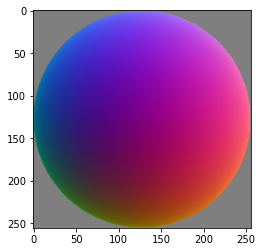

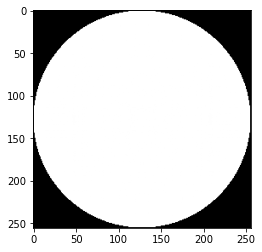

In [2]:
# Create the "Normal map of sphere" using 
img_size = 256
x = np.linspace(-1, 1, img_size)
z = np.linspace(1, -1, img_size)
x, z = np.meshgrid(x, z)

mag = np.sqrt(x**2 + z**2)
valid = mag <=1
y = -np.sqrt(1 - (x*valid)**2 - (z*valid)**2)
x = x * valid
y = y * valid
z = z * valid
normal = np.stack((x, y, z), axis=2)    # Forming x, y, z to Normal maps
plt.imshow((((normal + 1)/2)*255).astype(np.uint8))
plt.show()
norm = np.sqrt(np.sum(normal**2, axis=-1))
plt.imshow(np.stack([norm]*3, axis=-1))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


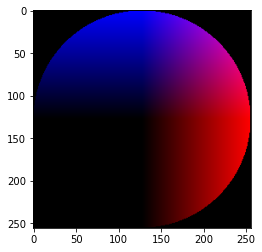

magnitue of normals = (256, 256)


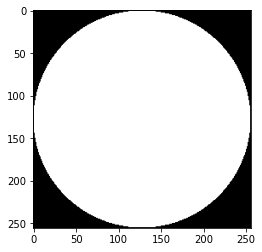

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


N=(1, 3, 256, 256), N[:, 0]=(1, 256, 256)
sh=(1, 9, 256, 256), constant_factor=(9,), sh_coeff=(1, 9, 3)
shading before sum = (1, 9, 3, 256, 256)
final shading shape = (1, 3, 256, 256), min=0.12658406478369477, max=1.7801447406000277


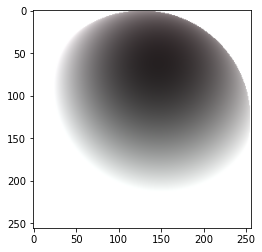

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


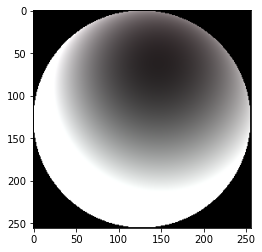

In [3]:
normal_maps = np.transpose(normal, (2, 0, 1))[None, ...]
light = params_valid['60010.jpg']['light'].reshape(9, 3)[None, ...]
shading_images = add_SHlight(normal_images=normal_maps, sh_coeff=light)
plt.imshow(np.transpose((shading_images * valid)[0], (1, 2, 0)))
plt.show()